<a href="https://colab.research.google.com/github/Chromis07/GAN-in-action/blob/main/code/ch3_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [27]:
# 모델 입력 차원
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels) # 입력 이미지 차원

z_dim = 100 # 생성자의 입력으로 사용될 잡음 벡터의 크기

# 생성자

In [37]:
def build_generator(img_shape, z_dim):
  model = Sequential()

  # 완전 연결층
  model.add(Dense(128, input_dim = z_dim))

  # LeakyReLU 활성화 함수 (gradient가 사라지는 것을 막기 위해 ReLU 대신 사용)
  model.add(LeakyReLU(alpha=0.01))

  # tanh 활성화 함수를 사용한 출력층 (sigmoid 보다 더 또렷하게 이미지 생성)
  model.add(Dense(28 * 28 * 1, activation= 'tanh'))

  # 생성자의 출력을 이미지 차원으로 변경
  model.add(Reshape(img_shape))

  return model

# 판별자

In [38]:
def build_discriminator(img_shape):
  model = Sequential()

  # 입력 이미지를 일렬로 펼치기
  model.add(Flatten(input_shape=img_shape))

  # 완전 연결층
  model.add(Dense(128))

  # LeakyReLU 활성화 함수
  model.add(LeakyReLU(alpha=0.01))

  # 시그모이드 활성화 함수를 사용한 출력층 (판별하는 확률 계산을 위해 사용)
  model.add(Dense(1, activation='sigmoid'))

  return model

# 모델 만들기

In [39]:
def build_gan(generator, discriminator):
  model = Sequential()

  # 생성자 -> 판별자로 연결된 모델
  model.add(generator)
  model.add(discriminator)

  return model

In [40]:
# 판별자 모델을 만들고 컴파일하기 (독립적)
discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy', # 2개의 클래스만 있는 예측에서 계산된 확률, 진짜 확률 차이 측정
                      optimizer = Adam(),
                      metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator(img_shape, z_dim)

# 생성자를 훈련하는 동안 판별자의 파라미터를 유지
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# 훈련

In [44]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

  # MNIST 데이터셋 로드
  (X_train, _), (_, _) = mnist.load_data()

  # [0, 255] 흑백 픽셀 값을 [-1, 1] 시이로 스케일 조정
  X_train = X_train / 127.5 - 1.0
  X_train = np.expand_dims(X_train, axis=3)

  # 원 핫 인코딩
  # 진짜 이미지 레이블 : 모두 1
  real = np.ones((batch_size, 1))

  # 가짜 이미지 레이블 : 모두 0
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations) :
    # -------------------------
    #  판별자 훈련
    # -------------------------

    # 진짜 이미지에서 랜덤 배치 가져오기
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # 가짜 이미지 배치 생성
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # 판별자 훈련
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # -------------------------
    #  생성자 훈련
    # -------------------------
    
    # 가짜 이미지 배치 생성
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # 생성자 훈련
    g_loss = gan.train_on_batch(z, real)

    if (iteration + 1) % sample_interval == 0:

      # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      # 훈련 과정 출력
      print(f"{iteration + 1} [D 손실 : {d_loss}, 정확도 : {100.0 * accuracy:.2f}] \
       [G 손실 : {g_loss}]")
      
      # 생성된 이미지 샘플 출력
      sample_images(generator)

In [45]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

  # 랜덤한 잡음 샘플링
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # 랜덤한 잡음에서 이미지 생성하기
  gen_imgs = generator.predict(z)

  # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
  gen_imgs = 0.5 * gen_imgs + 0.5

  # 이미지 그리드 설정
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4, 4),
                          sharey=True,
                          sharex=True)

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # 이미지 그리드 출력
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1

# GAN 훈련과 출력 점검

케라스의 `'Discrepancy between trainable weights and collected trainable'` 경고는 예상한 것입니다. 원래 설계가 판별자를 훈련하는 동안 생성자의 훈련 파라미터를 고의로 일정하게 유지했고 그 반대의 경우도 마찬가지입니다.

1000 [D 손실 : 0.062106918543577194, 정확도 : 99.22]        [G 손실 : 3.6669397354125977]
2000 [D 손실 : 0.166327353566885, 정확도 : 93.75]        [G 손실 : 4.000494956970215]
3000 [D 손실 : 0.1252068281173706, 정확도 : 95.70]        [G 손실 : 4.493516445159912]
4000 [D 손실 : 0.1490354686975479, 정확도 : 95.31]        [G 손실 : 5.417109489440918]
5000 [D 손실 : 0.18904676660895348, 정확도 : 92.97]        [G 손실 : 4.77578067779541]
6000 [D 손실 : 0.19792094081640244, 정확도 : 90.62]        [G 손실 : 4.96724796295166]
7000 [D 손실 : 0.37965746223926544, 정확도 : 83.20]        [G 손실 : 3.989211082458496]
8000 [D 손실 : 0.2922075688838959, 정확도 : 89.45]        [G 손실 : 3.291382312774658]
9000 [D 손실 : 0.41857069730758667, 정확도 : 83.98]        [G 손실 : 3.2187275886535645]
10000 [D 손실 : 0.570363849401474, 정확도 : 77.73]        [G 손실 : 2.7899069786071777]
11000 [D 손실 : 0.3040706589818001, 정확도 : 87.11]        [G 손실 : 3.4863224029541016]
12000 [D 손실 : 0.28887374699115753, 정확도 : 86.72]        [G 손실 : 3.995614528656006]
13000 [D 손실 : 0.26102355867624

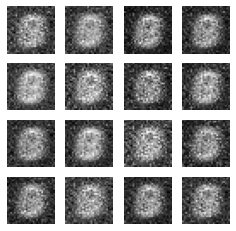

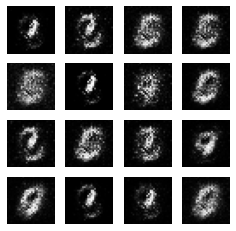

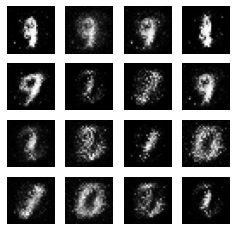

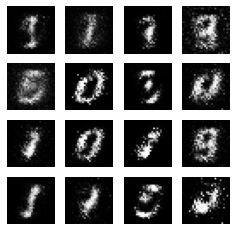

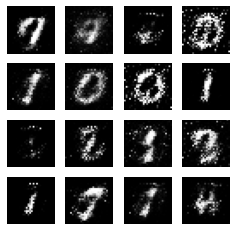

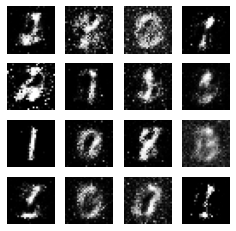

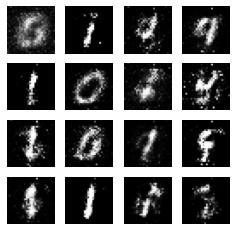

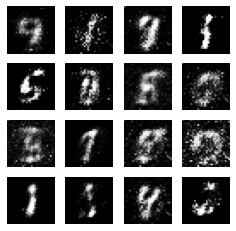

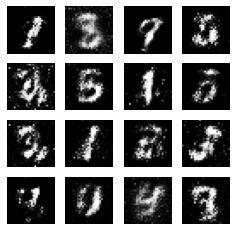

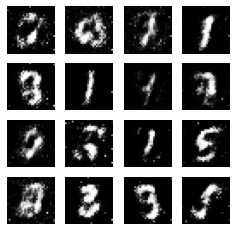

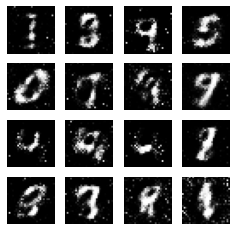

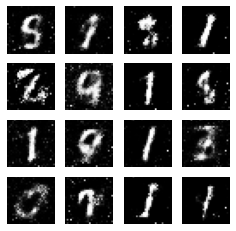

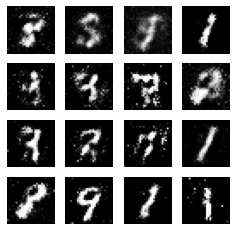

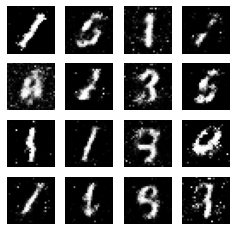

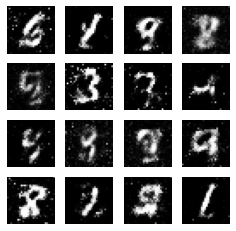

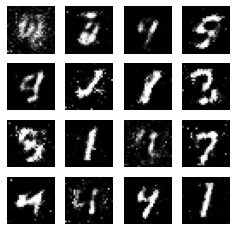

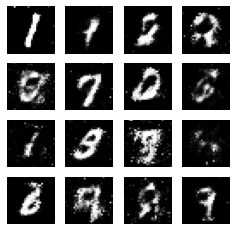

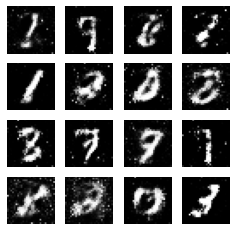

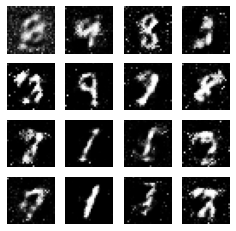

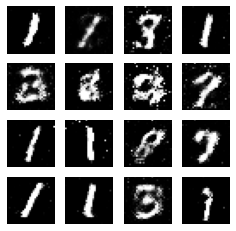

In [46]:
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 GAN 훈련
train(iterations, batch_size, sample_interval)

생성자는 판별자의 거짓 양성 분류가 최대가 되길 바란다<br>
판별자는 거짓 양성과 거짓 음성 분류를 최소화하길 원한다.